# Fraud Detection Overview

Fraud detection is one of the most important applications in data science, as the ability to detect fraud helps establish consumer trust and corporate integrity. Not to mention, eliminating fraud would prevent millions, if not billions, of dollars worth of loss and damages.

Depending on the data, running classification algorithms like logistic regression and SVM to detect fraud is relatively uncomplicated. There are the usual steps of collecting the data, cleaning it, and then running it through multiple models to obtain the best metric. To save time, automated machine learning programs can iterate through many machine learning and deep learning models to find the one that provides the best performance. 

The datasets contains transactions made by credit cards in September 2013 by european cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, classification_report, f1_score, recall_score,roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn import tree, svm
from sklearn.linear_model import LogisticRegression
import h2o
from h2o.automl import H2OAutoML

In [2]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


There are over 280000 entries of data and going through all of that would be very computationally expensive, so lets just take a small sample as the train and test set. 

In [3]:
#Save the first 50000 entries as training data
df[0:50000].to_csv('train.csv')

In [4]:
train = pd.read_csv('train.csv')
train.shape

(50000, 32)

In [26]:
remain_df = df[50000:]

print(remain_df[remain_df['Class']==0].shape)
print(remain_df[remain_df['Class']==1].shape)


(234463, 31)
(344, 31)


In [32]:
test_no_fraud = remain_df[remain_df['Class']==0].sample(344)
test_fraud = remain_df[remain_df['Class']==1]

test = pd.concat([test_no_fraud, test_fraud])

print('Test set shape:', test.shape)
print('Not Fraud Cases:', test[test['Class']==0].shape[0])
print('Fraud Cases', test[test['Class']==1].shape[0])
test.head()

Test set shape: (688, 31)
Not Fraud Cases: 344
Fraud Cases 344


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
279182,168693.0,-2.410025,-1.432871,1.373919,-2.507625,-1.697742,-0.544289,-1.293413,0.849440,-2.024631,...,0.044517,-0.026928,-0.232544,-0.100905,0.384982,-0.207308,-0.205183,-0.327786,101.96,0
174434,121911.0,1.693089,-0.557008,-1.805554,0.605396,-0.206261,-1.161832,0.250070,-0.234809,1.194721,...,-0.157763,-0.617990,0.051895,-0.223845,-0.172443,-0.094935,-0.043064,0.004020,176.95,0
206671,136313.0,2.159707,-0.542620,-2.882846,-0.961864,0.676114,-0.672313,0.138164,-0.292709,-1.015015,...,0.287876,0.759384,-0.198479,-0.002659,0.533916,0.096507,-0.073622,-0.056786,62.59,0
108086,70757.0,1.094891,-0.052185,-0.024230,1.255481,0.159614,0.307443,0.115648,0.039560,0.394113,...,-0.120580,-0.273670,-0.220620,-0.764709,0.738397,-0.266104,0.024003,0.018231,74.89,0
184653,126327.0,-0.063378,0.129319,1.302245,0.281004,-1.039008,0.252654,-0.367685,0.327396,1.867043,...,0.212056,0.940081,0.036176,-0.120481,-0.963518,-0.262713,0.138978,0.150663,70.55,0


## Data Analysis

In [19]:
#provides overview of data types to see if any categorical data needs to be encoded; none here
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 32 columns):
Unnamed: 0    50000 non-null int64
Time          50000 non-null float64
V1            50000 non-null float64
V2            50000 non-null float64
V3            50000 non-null float64
V4            50000 non-null float64
V5            50000 non-null float64
V6            50000 non-null float64
V7            50000 non-null float64
V8            50000 non-null float64
V9            50000 non-null float64
V10           50000 non-null float64
V11           50000 non-null float64
V12           50000 non-null float64
V13           50000 non-null float64
V14           50000 non-null float64
V15           50000 non-null float64
V16           50000 non-null float64
V17           50000 non-null float64
V18           50000 non-null float64
V19           50000 non-null float64
V20           50000 non-null float64
V21           50000 non-null float64
V22           50000 non-null float64
V23  

In [20]:
#overview if any null values are present; none here
train.isna().sum()

Unnamed: 0    0
Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
dtype: int64

In [21]:
#a good way to find placeholder nulls in numerical data. Usually this means looking at the min/max of each feature for any
#extremes; data doesn't seem to contain placeholder nulls or outliers
train.describe()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,28923.779620,-0.242344,0.010316,0.692829,0.185482,-0.258043,0.105202,-0.120580,0.053704,...,-0.028909,-0.106878,-0.039899,0.008362,0.135912,0.020885,0.004915,0.004232,93.266587,0.002960
std,14433.901067,13116.563925,1.887731,1.629766,1.508700,1.400009,1.412611,1.311299,1.282493,1.223824,...,0.736011,0.637858,0.589736,0.594216,0.439013,0.501260,0.388101,0.334785,253.010040,0.054326
min,0.000000,0.000000,-56.407510,-72.715728,-32.965346,-5.172595,-42.147898,-26.160506,-26.548144,-41.484823,...,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.577118,-8.567638,-9.617915,0.000000,0.000000
25%,12499.750000,21893.500000,-0.992599,-0.564348,0.216729,-0.721295,-0.867721,-0.635255,-0.606146,-0.146744,...,-0.231454,-0.529526,-0.178930,-0.321902,-0.127945,-0.330577,-0.063231,-0.006699,7.627500,0.000000
50%,24999.500000,33471.500000,-0.245008,0.078253,0.795902,0.191131,-0.289438,-0.150443,-0.077294,0.058736,...,-0.068160,-0.082056,-0.051642,0.062302,0.175743,-0.071973,0.009035,0.022174,25.000000,0.000000
75%,37499.250000,38983.000000,1.155544,0.731591,1.430980,1.067868,0.283011,0.495431,0.423920,0.332187,...,0.108087,0.307440,0.078620,0.401568,0.422121,0.300405,0.083875,0.076303,85.250000,0.000000
max,49999.000000,44299.000000,1.960497,18.183626,4.101716,16.491217,34.801666,22.529298,36.677268,20.007208,...,22.614889,5.805795,17.297845,4.014444,5.525093,3.517346,11.135740,33.847808,12910.930000,1.000000


<BarContainer object of 2 artists>

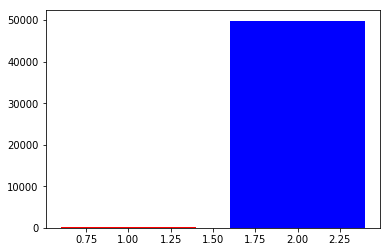

In [10]:
no_fraud = train[train['Class']==0].shape[0]
fraud = train[train['Class']==1].shape[0]

plt.bar(x=[1,2], height = [fraud, no_fraud], color = ['red', 'blue'])

There's a great imbalance between fraudulent and non-fraudulent cases, which will affect our algorithms. Therefore, it's necessary to balance these classes. 

## Balancing Classes with SMOTE

There are a lot of ways to balance classes of data. The simplest would be to just oversample the minority class. However, there are other heuristic methods like SMOTE and Adasyn that we can use. In this case, we'll use SMOTE (Synthetic Minority Oversample Technique). 

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

#separate features/target
X = train.loc[:, train.columns != 'Class']
y = train['Class']

#train, test, split 
os = SMOTE(random_state=117)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=117)

#fit SMOTE to training data
columns = X_train.columns
os_data_X, os_data_y=os.fit_sample(X_train, y_train)

#create two dataframes with oversampled data
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Class'])

In [12]:
# Check the numbers
print("length of oversampled data is ",len(os_data_X))
print("Number of not fraud in oversampled data",len(os_data_y[os_data_y['Class']==0]))
print("Number of fraud",len(os_data_y[os_data_y['Class']==1]))
print("Proportion of not fraud in oversampled data is ",len(os_data_y[os_data_y['Class']==0])/len(os_data_X))
print("Proportion of fraud data in oversampled data is ",len(os_data_y[os_data_y['Class']==1])/len(os_data_X))

length of oversampled data is  79758
Number of not fraud in oversampled data 39879
Number of fraud 39879
Proportion of not fraud in oversampled data is  0.5
Proportion of fraud data in oversampled data is  0.5


In [13]:
#combine the features and target into one dataframe
os_train = os_data_X
os_train['Class'] = os_data_y.values
os_train.head()

,Unnamed: 0,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,23573,32828.0,0.601467,-0.972097,-0.836823,0.285860,-0.246023,-0.971890,1.018488,-0.529431,...,0.168925,-0.323254,-0.505600,0.017159,0.509378,1.056221,-0.181210,0.056364,399.00,0
1,46656,42873.0,-0.992590,-0.329359,2.326593,-0.695860,0.032342,0.340383,0.056838,0.196443,...,-0.141609,-0.103302,-0.134270,-0.417595,0.304661,-0.375699,-0.108228,-0.153287,65.00,0
2,6358,7577.0,-0.318075,1.062283,1.759506,1.003932,0.426871,0.449983,0.604184,-0.124242,...,-0.199046,-0.065634,-0.163249,-0.574275,-0.229511,-0.414992,0.214577,-0.031305,36.00,0
3,13801,24468.0,-9.970943,-4.156007,0.059100,2.745572,2.812815,-1.567950,1.336645,-2.428785,...,-3.340266,1.091950,3.545291,0.601934,1.824614,0.045613,2.200767,-1.341030,18.14,0
4,15669,27089.0,-0.413949,1.112684,1.586218,-0.041054,0.026548,-0.881305,0.757186,-0.118384,...,-0.217986,-0.518803,-0.036909,0.386680,-0.162144,0.068418,0.271848,0.122978,0.89,0


<BarContainer object of 2 artists>

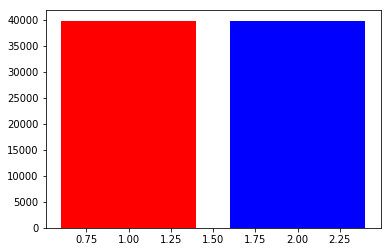

In [14]:
#check the classes again to see if it's balanced
no_fraud = os_train[os_train['Class']==0].shape[0]
fraud = os_train[os_train['Class']==1].shape[0]

plt.bar(x=[1,2], height = [fraud, no_fraud], color = ['red', 'blue'])

## Comparing Oversampling with Balanced Weights

In [122]:
os_train_X = os_train[os_train.columns[2:-1]]
os_train_y = os_train['Class']

X_test = test[test.columns[1:-1]]
y_test = test['Class']

In [68]:
support = svm.SVC(random_state = 117)
dec_tree = tree.DecisionTreeClassifier(random_state = 117)
logreg =  LogisticRegression(random_state = 117)


In [124]:
classifiers = [dec_tree, support, logreg]
classifier_names = ['Decision Tree', 'SVM', 'Logistic Regression']
score_array = []

for i, clf in enumerate(classifiers):
    score_list = []
    score_list.append(classifier_names[i])
    clf.fit(os_train_X, os_train_y)
    clf_pred = clf.predict(X_test)
    score_list.append(round(accuracy_score(y_true, clf_pred),2))
    score_list.append(round(recall_score(y_true, clf_pred),2))
    score_list.append(round(f1_score(y_true, clf_pred),2))
    score_list.append(round(roc_auc_score(y_test, clf_pred),2))
    score_array.append(score_list)
    
os_report = pd.DataFrame(np.array(score_array),
columns=['Algorithm', 'Accuracy', 'Recall', 'F1 Score', 'ROC AUC'])

os_report

,Algorithm,Accuracy,Recall,F1 Score,ROC AUC
0,Decision Tree,0.83,0.68,0.8,0.83
1,SVM,0.88,0.76,0.86,0.88
2,Logistic Regression,0.91,0.85,0.91,0.91


In [120]:
x_train = train[train.columns[2:-1]]
y_train = train['Class']
score_array = []

bal_support = svm.SVC(class_weight ='balanced', random_state = 117)
bal_dec_tree = tree.DecisionTreeClassifier(class_weight ='balanced', random_state = 117)
bal_logreg =  LogisticRegression(class_weight ='balanced', random_state = 117)

bal_classifiers = [bal_dec_tree, bal_support, bal_logreg]


for i, clf in enumerate(bal_classifiers):
    score_list = []
    score_list.append(classifier_names[i])
    clf.fit(x_train, y_train)
    clf_pred = clf.predict(X_test)
    score_list.append(round(accuracy_score(y_true, clf_pred),2))
    score_list.append(round(recall_score(y_true, clf_pred),2))
    score_list.append(round(f1_score(y_true, clf_pred),2))
    score_list.append(round(roc_auc_score(y_test, clf_pred),2))
    score_array.append(score_list)

bal_report = pd.DataFrame(np.array(score_array),
columns=['Algorithm', 'Accuracy', 'Recall', 'F1 Score', 'ROC AUC'])

bal_report

,Algorithm,Accuracy,Recall,F1 Score,ROC AUC
0,Decision Tree,0.8,0.6,0.75,0.8
1,SVM,0.88,0.77,0.87,0.88
2,Logistic Regression,0.92,0.88,0.92,0.92


In [ ]:
def run_h2o(df,target,model_number):
    
    """
    Function initiates an h2o cluster, converts
    the dataframe to an h2o dataframe, and then runs
    the autoML function to generate a list of optimal 
    predictor models, which are displayed on a scoreboard
    
    Arguments:
        dataframe: Pandas dataframe. 
        target: String. Name of the predicted target
        model_number: Int. Total number of models to run.
        
    Outputs:
        prints Leader board of best performing models in the console
        returns aml model
    """
    #initiate cluser
    h2o.init()
    
    #turn pandas to h2o dataframe
    dataframe = h2o.H2OFrame(df)

    #make sure the target is categorical
    dataframe[target] = dataframe[target].asfactor()
    
    #Declare the x- and y- variables for the database. 
    #x-variables are predictor variables, and y-variable is what
    #we wish to predict
    x = dataframe.columns
    y = target
    
    x.remove(y)

    #Pull the training and test data out at a 80/20 split.
    train, test, val = dataframe.split_frame(ratios=[.8, .1])
    
    # Run AutoML for N base models (limited to 1 hour max runtime by default); set the metric to AUC
    aml = H2OAutoML(max_models=model_number,  sort_metric = 'AUC', seed=117)
    aml.train(x=x, y=y, training_frame=train, validation_frame = val)

    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb.head(rows=lb.nrows))
    
    #returns the h2o aml models
    return aml

In [ ]:
#run the function
h2o_aml = run_h2o(os_train, 'Class', 10)

In [ ]:
#describes the leading model along with various metrics and confusion matrix
h2o_aml.leader

In [ ]:
#Get performance on test data
test_h2o = h2o.H2OFrame(test)
h2o_aml.leader.model_performance(test_data=test_h2o)

In [90]:
def make_auc_roc(clf, x_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, thres = roc_curve(y_test, y_pred)
    auc= roc_auc_score(y_test, y_pred)
    plt.plot(fpr, tpr, label='AUC ROC Cruve')
    plt.legend(loc=4)
    plt.show()

### Analysis of H2O AutoML on SMOTE Data
It seems the models most likely overfitted on training data. Precision and accuracy seem good, but this is definitely inflated since the number of fraudulent cases in the test file are just so scarce. This is reflected in the recall score of .56

H2O has its own oversampling parameter, so lets see how it fares. 

In [126]:
#shut down the previous cluster
h2o.shutdown()

C:\Users\Thien_Nguyen\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  


H2O session _sid_85a2 was not closed properly.


In [30]:
def run_h2o(df,target,model_number):
    
    """
    Function initiates an h2o cluster, converts
    the dataframe to an h2o dataframe, and then runs
    the autoML function to generate a list of optimal 
    predictor models, which are displayed on a scoreboard
    
    Arguments:
        dataframe: Pandas dataframe. 
        target: String. Name of the predicted target
        model_number: Int. Total number of models to run.
        
    Outputs:
        prints Leader board of best performing models in the console
        returns aml model
    """
    
    h2o.init()

    dataframe = h2o.H2OFrame(df)
    
    dataframe[target] = dataframe[target].asfactor()
    
    #Declare the x- and y- variables for the database. 
    #x-variables are predictor variables, and y-variable is what
    #we wish to predict
    x = dataframe.columns
    y = target
    
    x.remove(y)

    #Pull the training and test data out at a 80/20 split.
    train, test, val = dataframe.split_frame(ratios=[.8, .1])
    
    # Run AutoML for 20 base models (limited to 1 hour max runtime by default); set balance classes to True
    aml = H2OAutoML(max_models=model_number,  sort_metric = 'AUC', balance_classes =True, seed=117)
    aml.train(x=x, y=y, training_frame=train, validation_frame = val)

    # View the AutoML Leaderboard
    lb = aml.leaderboard
    print(lb.head(rows=lb.nrows))
    
    return aml

In [31]:
h2o_aml = run_h2o(train, 'Class', 10)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.7+8-LTS, mixed mode)
  Starting server from C:\Users\Thien_Nguyen\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\THIEN_~1\AppData\Local\Temp\tmpey8xgjfb
  JVM stdout: C:\Users\THIEN_~1\AppData\Local\Temp\tmpey8xgjfb\h2o_Thien_Nguyen_started_from_python.out
  JVM stderr: C:\Users\THIEN_~1\AppData\Local\Temp\tmpey8xgjfb\h2o_Thien_Nguyen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Chicago
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.2
H2O_cluster_version_age:,9 days
H2O_cluster_name:,H2O_from_python_Thien_Nguyen_drtb2y
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.973 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |
16:46:57.338: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.
16:46:57.356: AutoML: XGBoost is not available; skipping it.

████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_4_AutoML_20200508_164657,0.995546,0.00475649,0.951953,0.0424852,0.0223453,0.000499311
GBM_1_AutoML_20200508_164657,0.992612,0.00461577,0.945644,0.0509349,0.0232788,0.000541905
GBM_2_AutoML_20200508_164657,0.991536,0.00458362,0.94548,0.0467475,0.0229005,0.000524434
GBM_5_AutoML_20200508_164657,0.989422,0.00398139,0.951965,0.0212863,0.0232872,0.000542295
GBM_grid__1_AutoML_20200508_164657_model_1,0.989099,0.00531765,0.948948,0.0340481,0.0228042,0.000520034
GLM_1_AutoML_20200508_164657,0.985846,0.00467995,0.822095,0.127406,0.0323798,0.00104845
DeepLearning_1_AutoML_20200508_164657,0.985647,0.0119996,0.870157,0.0385351,0.0321247,0.001032
GBM_3_AutoML_20200508_164657,0.984958,0.00485707,0.944418,0.0720838,0.0225069,0.000506559
XRT_1_AutoML_20200508_164657,0.982854,0.0109205,0.950658,0.0213487,0.0424588,0.00180275
DRF_1_AutoML_20200508_164657,0.982835,0.0111887,0.952306,0.0213487,0.0427954,0.00183145


In [32]:
test_h2o = h2o.H2OFrame(test)
h2o_aml.leader.model_performance(test_data=test_h2o)

Parse progress: |█████████████████████████████████████████████████████████| 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.0008765146758255358
RMSE: 0.029605990539509665
LogLoss: 0.013648360645228723
Mean Per-Class Error: 0.20966449674511767
AUC: 0.7628242363545318
AUCPR: 0.5370671929248207
Gini: 0.5256484727090636

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00079726206533019: 


,,0,1,Error,Rate
0,0,9985.0,0.0,0.0,(0.0/9985.0)
1,1,7.0,8.0,0.4667,(7.0/15.0)
2,Total,9992.0,8.0,0.0007,(7.0/10000.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,7.972621e-04,0.695652,7.0
1,max f2,7.972621e-04,0.588235,7.0
2,max f0point5,7.972621e-04,0.851064,7.0
3,max accuracy,7.972621e-04,0.999300,7.0
4,max precision,9.903052e-01,1.000000,0.0
5,max recall,1.233421e-08,1.000000,339.0
6,max specificity,9.903052e-01,1.000000,0.0
7,max absolute_mcc,7.972621e-04,0.730041,7.0
8,max min_per_class_accuracy,1.743218e-08,0.600000,173.0
9,max mean_per_class_accuracy,1.743218e-08,0.790336,173.0



Gains/Lift Table: Avg response rate:  0.15 %, avg score:  0.05 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.0100,2.260419e-08,53.333333,53.333333,0.080000,5.410931e-02,0.080000,0.054109,0.533333,0.533333,5233.333333,5233.333333
1,,2,0.0200,1.743310e-08,6.666667,30.000000,0.010000,1.931621e-08,0.045000,0.027055,0.066667,0.600000,566.666667,2900.000000
2,,3,0.0300,1.517341e-08,0.000000,20.000000,0.000000,1.619059e-08,0.030000,0.018036,0.000000,0.600000,-100.000000,1900.000000
3,,4,0.0400,1.470287e-08,0.000000,15.000000,0.000000,1.491806e-08,0.022500,0.013527,0.000000,0.600000,-100.000000,1400.000000
4,,5,0.0500,1.421021e-08,0.000000,12.000000,0.000000,1.444032e-08,0.018000,0.010822,0.000000,0.600000,-100.000000,1100.000000
5,,6,0.1000,1.299733e-08,0.000000,6.000000,0.000000,1.331535e-08,0.009000,0.005411,0.000000,0.600000,-100.000000,500.000000
6,,7,0.1500,1.233657e-08,0.000000,4.000000,0.000000,1.252912e-08,0.006000,0.003607,0.000000,0.600000,-100.000000,300.000000
7,,8,0.2157,1.233635e-08,0.000000,2.781641,0.000000,1.233640e-08,0.004172,0.002509,0.000000,0.600000,-100.000000,178.164117
8,,9,0.3025,1.233632e-08,1.536098,2.424242,0.002304,1.233633e-08,0.003636,0.001789,0.133333,0.733333,53.609831,142.424242
9,,10,0.4005,1.233628e-08,0.000000,1.831045,0.000000,1.233629e-08,0.002747,0.001351,0.000000,0.733333,-100.000000,83.104453


Oversampling via H2O doesn't solve the issue either since overfitting is still occurring. However, it is difficult to ascertain a high recall exclusively since there are only 15 cases of fraudulent behavior in the test file.

In [18]:
"""A classification example using mlbox."""
from mlbox.preprocessing import Reader
from mlbox.preprocessing import Drift_thresholder
from mlbox.optimisation import Optimiser
from mlbox.prediction import Predictor

# Paths to the train set and the test set.
paths = ["train.csv", "test.csv"]
# Name of the feature to predict.
# This columns should only be present in the train set.
target_name = "Class"

# Reading and cleaning all files
# Declare a reader for csv files
rd = Reader(sep=',')

# Return a dictionnary containing three entries
# dict["train"] contains training samples withtout target columns
# dict["test"] contains testing elements withtout target columns
# dict["target"] contains target columns for training samples.
data = rd.train_test_split(paths, target_name)


reading csv : train.csv ...
cleaning data ...
CPU time: 1.0247461795806885 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.26402807235717773 seconds

You have no test dataset !

> Number of common features : 30

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 30
> Number of training samples : 59753
> Number of test samples : 0

> You have no missing values on train set...

> Task : classification
0.0    59590
1.0      163
Name: Class, dtype: int64

encoding target ...


In [20]:
"""A classification example using mlbox."""
from mlbox.preprocessing import Reader
from mlbox.preprocessing import Drift_thresholder
from mlbox.optimisation import Optimiser
from mlbox.prediction import Predictor

# Paths to the train set and the test set.
paths = ["train.csv", "test.csv"]
# Name of the feature to predict.
# This columns should only be present in the train set.
target_name = "Class"

# Reading and cleaning all files
# Declare a reader for csv files
rd = Reader(sep=',')
# Return a dictionnary containing three entries
# dict["train"] contains training samples withtout target columns
# dict["test"] contains testing elements withtout target columns
# dict["target"] contains target columns for training samples.
data = rd.train_test_split(paths, target_name)

dft = Drift_thresholder()
data = dft.fit_transform(data)

# Tuning
# Declare an optimiser. Scoring possibilities for classification lie in :
# {"accuracy", "roc_auc", "f1", "neg_log_loss", "precision", "recall"}
opt = Optimiser(scoring='recall', n_folds=5)
opt.evaluate(None, data)

# Space of hyperparameters
# The keys must respect the following syntax : "enc__param".
#   "enc" = "ne" for na encoder
#   "enc" = "ce" for categorical encoder
#   "enc" = "fs" for feature selector [OPTIONAL]
#   "enc" = "stck"+str(i) to add layer n°i of meta-features [OPTIONAL]
#   "enc" = "est" for the final estimator
#   "param" : a correct associated parameter for each step.
#   Ex: "max_depth" for "enc"="est", ...
# The values must respect the syntax: {"search":strategy,"space":list}
#   "strategy" = "choice" or "uniform". Default = "choice"
#   list : a list of values to be tested if strategy="choice".
#   Else, list = [value_min, value_max].
# Available strategies for ne_numerical_strategy are either an integer, a float
#   or in {'mean', 'median', "most_frequent"}
# Available strategies for ce_strategy are:
#   {"label_encoding", "dummification", "random_projection", entity_embedding"}
space = {'ne__numerical_strategy': {"search": "choice", "space": [0]},
         'ce__strategy': {"search": "choice",
                          "space": ["label_encoding",
                                    "random_projection",
                                    "entity_embedding"]},
         'fs__threshold': {"search": "uniform",
                           "space": [0.01, 0.3]},
         'est__max_depth': {"search": "choice",
                            "space": [3, 4, 5, 6, 7]}

         }

# Optimises hyper-parameters of the whole Pipeline with a given scoring
# function. Algorithm used to optimize : Tree Parzen Estimator.
#
# IMPORTANT : Try to avoid dependent parameters and to set one feature
# selection strategy and one estimator strategy at a time.
best = opt.optimise(space, data, 15)

# Make prediction and save the results in save folder.
prd = Predictor()
prd.fit_predict(best, data)


reading csv : train.csv ...
cleaning data ...
CPU time: 0.900773286819458 seconds

reading csv : test.csv ...
cleaning data ...
CPU time: 0.21503233909606934 seconds

You have no test dataset !

> Number of common features : 30

gathering and crunching for train and test datasets ...
reindexing for train and test datasets ...
dropping training duplicates ...
dropping constant variables on training set ...

> Number of categorical features: 0
> Number of numerical features: 30
> Number of training samples : 59753
> Number of test samples : 0

> You have no missing values on train set...

> Task : classification
0.0    59590
1.0      163
Name: Class, dtype: int64

encoding target ...

You have no test dataset...


C:\Users\Thien_Nguyen\AppData\Roaming\Python\Python37\site-packages\mlbox\optimisation\optimiser.py:74: UserWarning: Optimiser will save all your fitted models into directory 'save/joblib'. Please clear it regularly.
  +str(self.to_path)+"/joblib'. Please clear it regularly.")


No parameters set. Default configuration is tested

##################################################### testing hyper-parameters... #####################################################

>>> NA ENCODER :{'numerical_strategy': 'mean', 'categorical_strategy': '<NULL>'}

>>> CA ENCODER :{'strategy': 'label_encoding'}

>>> ESTIMATOR :{'strategy': 'LightGBM', 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 0.9, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'nthread': -1, 'seed': 0}


MEAN SCORE : recall = 0.8526515151515153
VARIANCE : 0.04168646223977218 (fold 1 = 0.8787878787878788, fold 2 = 0.8484848484848485, fold 3 = 0.8484848484848485, fold 4 = 0.90625, fold 

VARIANCE : 0.03615886949249391 (fold 1 = 0.7878787878787878, fold 2 = 0.8787878787878788, fold 3 = 0.8181818181818182, fold 4 = 0.84375, fold 5 = 0.78125)
CPU time: 22.79263949394226 seconds                                               
##################################################### testing hyper-parameters... #####################################################
>>> NA ENCODER :{'numerical_strategy': 0, 'categorical_strategy': '<NULL>'}       
>>> CA ENCODER :{'strategy': 'random_projection'}                                 
>>> FEATURE SELECTOR :{'strategy': 'l1', 'threshold': 0.18296197102936268}        
>>> ESTIMATOR :{'strategy': 'LightGBM', 'max_depth': 4, 'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.05, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda

C:\Users\Thien_Nguyen\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


CPU time: 5.294022798538208 seconds


C:\Users\Thien_Nguyen\AppData\Roaming\Python\Python37\site-packages\mlbox\prediction\predictor.py:392: UserWarning: Unable to get feature importances !
  warnings.warn("Unable to get feature importances !")
C:\Users\Thien_Nguyen\AppData\Roaming\Python\Python37\site-packages\mlbox\prediction\predictor.py:405: UserWarning: You have no test dataset. Cannot predict !
  warnings.warn("You have no test dataset. Cannot predict !")


## References:

1. H2O.ai. H2O AutoML, June 2017. URL http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html. H2O version 3.30.0.1.
2. https://mlbox.readthedocs.io/en/latest/



In [ ]:
import h2o
from h2o.automl import H2OAutoML


#initiate cluser
h2o.init()
    
#turn pandas to h2o dataframe
dataframe = h2o.H2OFrame(df)

#make sure the target is categorical
dataframe[target] = dataframe[target].asfactor()
    
#Declare the x- and y- variables for the database. 
#x-variables are predictor variables, and y-variable is what
#we wish to predict
x = dataframe.columns
y = target

#remove the target feature from the x columns
x.remove(y)

#Pull the training and test data out at a 80/20 split.
train, test = dataframe.split_frame(ratios=[.8, .2])
    
# Run AutoML for N base models (limited to 1 hour max runtime by default); set the metric to AUC
aml = H2OAutoML(max_models=model_number,  sort_metric = 'AUC', seed=117)
aml.train(x=x, y=y, training_frame=train, validation_frame = val)

# View the AutoML Leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))
    


In [ ]:
test_h2o = h2o.H2OFrame(test)
h2o_aml.leader.model_performance(test_data=test_h2o)

In [ ]:
#scale data
X= preprocessing.StandardScaler().fit(X).transform(X)

#Run PCA on the scaled features
pca = PCA()
pca.fit(X)

#plot a cumulative plot of explain variance to threshold
cumsum = np.cumsum(pca.explained_variance_ratio_)
dim = np.arange(len(cumsum))+1

plt.plot(dim,cumsum,'-',lw=3);

plt.xlabel('# of Components')
plt.ylabel('Variance Explained')
plt.title('Selecting the right number of Components')

plt.ylim([0,1.1]);